In [64]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scanpy as sc
import scipy.sparse as sp
from anndata import AnnData
import pandas as pd

In [2]:
np.random.seed(112358)

In [3]:
# Helper functions
def val2cellcolor(x):
    return (1,1-x,1-x)

In [26]:
cmap = {
    'Other':    [0.25, 0.25, 0.25, 1.],
    'mt-Co2':   [0.29, 0.00, 1.00, 1.],
    'S100a8':   [1.00, 0.47, 0.00, 1.],
    'S100a9':   [0.25, 1.00, 0.00, 1.],
    'Eef1a1':   [0.93, 0.00, 1.00, 1.],
    'Elane':    [0.00, 0.99, 1.00, 1.],
    'Fth1':     [0.00, 1.00, 0.30, 1.],
    'Gapdh':    [1.00, 0.00, 0.70, 1.],
    'Ngp':      [0.00, 0.20, 1.00, 1.],
    'Rpl23':    [0.00, 0.03, 1.00, 1.],
    'Rps23':    [1.00, 0.79, 0.00, 1.],
    'Srgn':     [0.00, 0.67, 1.00, 1.],
    'Tuba1b':   [0.89, 1.00, 0.00, 1.],
    'mt-Atp6':  [1.00, 0.16, 0.00, 1.],
    'mt-Co1':   [0.57, 1.00, 0.00, 1.],
    'mt-Cytb':  [0.00, 1.00, 0.00, 1.],
    'mt-Nd1':   [0.61, 0.00, 1.00, 1.],
    'mt-Nd4':   [1.00, 0.00, 0.10, 1.],
    'B2m':      [1.00, 0.58, 0.00, 1.],
    'Dlk1':     [0.00, 1.00, 0.20, 1.],
    'Ifitm1':   [0.68, 1.00, 0.00, 1.],
    'Ptma':     [1.00, 0.00, 0.70, 1.],
    'Rpl18a':   [1.00, 0.77, 0.00, 1.],
    'Rpl27a':   [0.87, 1.00, 0.00, 1.],
    'Rps17':    [0.00, 1.00, 0.80, 1.],
    'Rps24':    [1.00, 0.01, 0.00, 1.],
    'Rps25':    [0.00, 0.43, 1.00, 1.],
    'Set':      [0.00, 0.24, 1.00, 1.],
    'Ybx1':     [0.00, 0.82, 1.00, 1.],
    'mt-Nd2':   [1.00, 0.94, 0.00, 1.]
}
cmap = {x: np.array(cmap[x]) for x in cmap}

In [42]:
# Data location
# datdir = "/projects/p31512/aeh581/gexpParPCA/out2"
datdir = "./data/out3"

# Directory structure
pcadir = f"{datdir}/pca"
eigdir = f"{datdir}/pca/eig"
gnames_fname = f"./data/gene_names.txt"
gexp_fname = f"./data/gene_expr.npz"

imgdir = f"{datdir}/images"
os.makedirs(imgdir, exist_ok=True)

sc.settings.figdir = imgdir

In [43]:
# Load data

with open(f"{pcadir}/binsize.txt", 'r') as f:
    bin_size = int(f.read())
    
with open(f"{pcadir}/nboot.txt", 'r') as f:
    nboot = int(f.read())
    
with open(f"{pcadir}/nsamp.txt", 'r') as f:
    nsamp = int(f.read())

bin_psts = np.load(f"{pcadir}/bin_psts.npy")
gnames = np.genfromtxt(gnames_fname, dtype=str)

GEM_lil = sp.load_npz(gexp_fname).tolil()

In [44]:
# SCANPY Analysis
adata = AnnData(GEM_lil, dtype=GEM_lil.dtype)
adata.var_names = gnames

In [45]:
sc.pp.pca(adata)

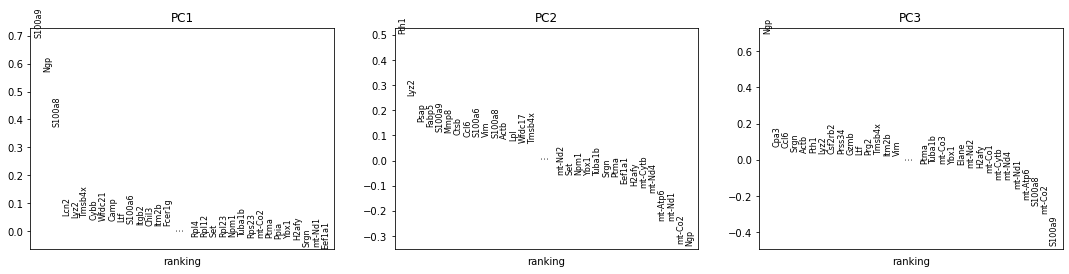

In [46]:
sc.pl.pca_loadings(adata, components = '1,2,3', save="_scanpy.png")

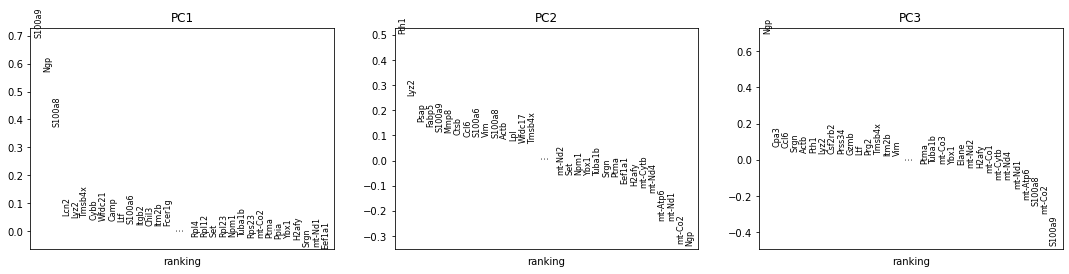

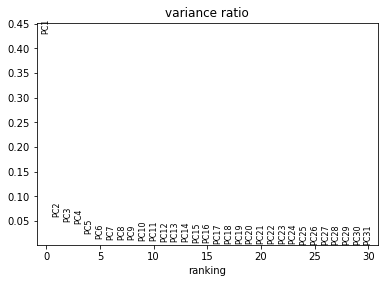

In [47]:
sc.pl.pca_overview(adata, save="_scanpy.png")

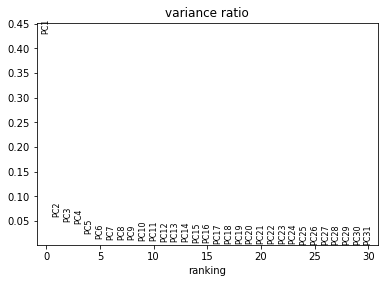

In [48]:
sc.pl.pca_variance_ratio(adata, save="_scanpy.png")

In [49]:
# Load data
evals_data = np.load(f"{eigdir}/dat_eval.npy")
evecs_data = np.load(f"{eigdir}/dat_evec.npy")

nbins, npca = evals_data.shape
ngenes = evecs_data.shape[2]

print(f"nbins: {nbins}")
print(f"npca: {npca}")
print(f"ngenes: {ngenes}")
print(f"nboot: {nboot}")
print(f"nsamp: {nsamp}")

nbins: 121
npca: 3
ngenes: 25289
nboot: 20
nsamp: 20


In [50]:
# Load bootstrap and nulls
evals_boot = np.zeros([nbins, nboot, npca])
evals_null = np.zeros([nbins, nboot, npca])
for i in range(nbins):
    evals_boot[i] = np.load(f"{eigdir}/boot_eval_t{i}.npy")
    evals_null[i] = np.load(f"{eigdir}/shuf_eval_t{i}.npy")
    

In [51]:
expvar_data = evals_data / np.sum(evals_data, axis=1)[:,None]
expvar_boot = evals_boot / np.sum(evals_boot, axis=2)[:,:,None]
expvar_null = evals_null / np.sum(evals_null, axis=2)[:,:,None]

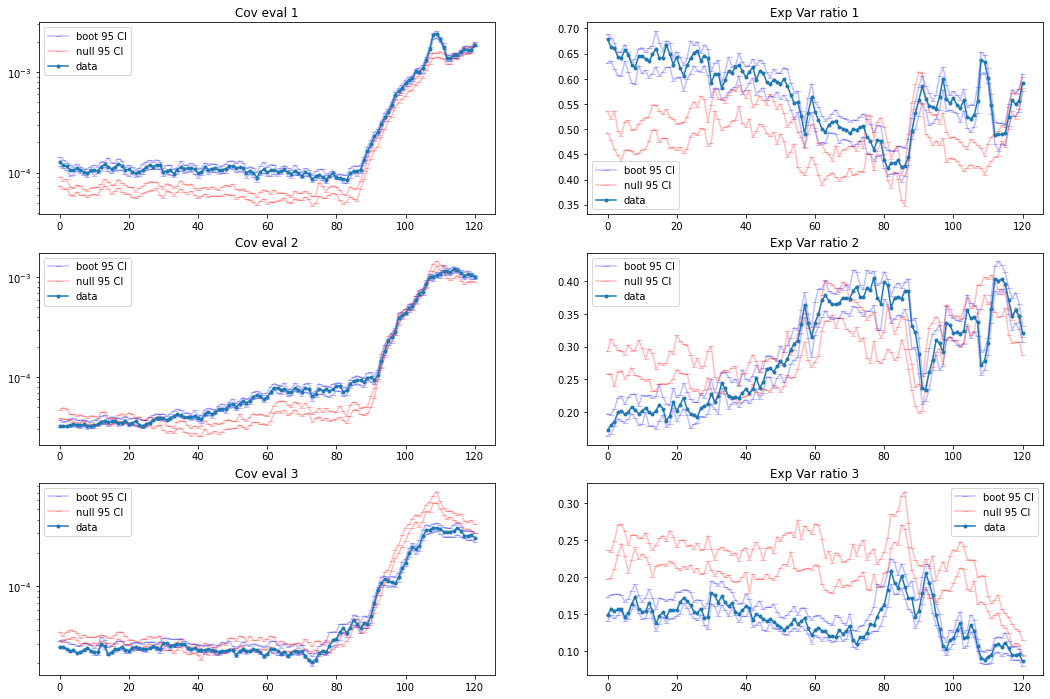

In [52]:
k = npca
fig, axes = plt.subplots(k, 2, figsize=(18,12))

for i in range(k):
    ax = axes[i][0]
    plotter = ax.semilogy
    plotter(np.percentile(evals_boot[:,:,i], 97.5, axis=1), 'b', alpha=0.25, marker='_', label='boot 95 CI');
    plotter(np.percentile(evals_boot[:,:,i], 2.5, axis=1), 'b', alpha=0.25, marker='_');
    plotter(np.percentile(evals_null[:,:,i], 97.5, axis=1), 'r', alpha=0.25, marker='_', label='null 95 CI');
    plotter(np.percentile(evals_null[:,:,i], 2.5, axis=1), 'r', alpha=0.25, marker='_');
    plotter(evals_data[:,i], marker='.', label='data')
    ax.set_title(f"Cov eval {i+1}")
    ax.legend()
    
for i in range(k):
    ax = axes[i][1]
    ax.plot(np.percentile(expvar_boot[:,:,i], 97.5, axis=1), 'b', alpha=0.25, marker='_', label='boot 95 CI');
    ax.plot(np.percentile(expvar_boot[:,:,i], 2.5, axis=1), 'b', alpha=0.25, marker='_');
    ax.plot(np.percentile(expvar_null[:,:,i], 97.5, axis=1), 'r', alpha=0.25, marker='_', label='null 95 CI');
    ax.plot(np.percentile(expvar_null[:,:,i], 2.5, axis=1), 'r', alpha=0.25, marker='_');
    ax.plot(expvar_data[:,i], marker='.', label='data')
    ax.set_title(f"Exp Var ratio {i+1}")
    ax.legend()

plt.savefig(f'{imgdir}/eval_plots.png')

In [53]:
# Location of maximum eigenvalue 1
max_idx = np.argmax(evals_data[:,0])
print(f"Max Eval Index: {max_idx}")

Max Eval Index: 109


In [54]:
primary_evecs = evecs_data[max_idx]
primary_evec_1 = primary_evecs[0]

In [55]:
print(np.min(primary_evec_1))
print(np.max(primary_evec_1))

-0.6219974111094267
0.37095695543025786


In [56]:
def eigenvector_loading_barchart(idx_subset, evec_subset, gnames, eps=0.01, 
                                 do_table=True, verbose=False, title=None, saveas=None, cmap=None, dpi=300):

    # Get indices of genes for which square of loading is greater than epsilon
    interesting_gene_idxs = np.unique(np.where(evec_subset**2 > eps)[1])
    interesting_gene_names = gnames[interesting_gene_idxs]
    num_int_genes = len(interesting_gene_idxs)
    if verbose:
        print(f"Interesting Genes ({num_int_genes}):\n{interesting_gene_names}")

    # Collect data (squared loadings) for interesting genes. Recall must sum to 1.
    data = np.zeros([num_int_genes+1, len(idx_subset)])
    for i, idx in enumerate(idx_subset):
        evec = evecs_data[idx, 0]
        data[:-1,i] = evec[interesting_gene_idxs]**2
        data[-1,i] = 1 - np.sum(data[:-1,i])  # all other loadings
    
    columns = idx_subset
    rows = list(interesting_gene_names) + ['Other']

    # Get colors
    colors = plt.cm.gist_rainbow(np.linspace(0, 1, len(rows)))
    np.random.shuffle(colors)
    if cmap:
        colormap = {}
        for i, rowname in enumerate(rows):
            if rowname in cmap:
                colormap[rowname] = cmap[rowname]
                colors[i] = cmap[rowname]
            else:
                colormap[rowname] = colors[i]
        colormap = {**cmap, **colormap}
    else: 
        colormap = {rows[i]: colors[i] for i in range(len(rows))}
    
    n_rows = len(data)

    index = np.arange(0,1,1/len(columns)) + 1/len(columns)/2
    bar_width = 0.50 * 1/len(columns)

    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(columns))

    fig, ax = plt.subplots(1, 1, figsize=(24,18), dpi=dpi)

    # Plot bars and create text labels for the table
    cell_text = []
    cell_colors = []
    for row in range(n_rows):
        ax.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
        y_offset = y_offset + data[row]
        if do_table:
            cell_text.append([f'{x:.2g}' for x in data[row]])
            cell_colors.append([val2cellcolor(x) for x in data[row]])
    
    # Reverse colors and text labels to display the last value at the top.
    colors = colors[::-1]
    if do_table:
        cell_text.reverse()
        cell_colors.reverse()
        rows.reverse()

    # Add a table at the bottom of the axes
    if do_table:
        the_table = ax.table(cellText=cell_text,
                             rowLabels=rows,
                             rowColours=[[*r[0:-1], 0.75] for r in colors],
                             colLabels=columns,
                             loc='bottom', 
                             cellColours=cell_colors
                            )
    ax.set_xlim([0,1])
    ax.set_ylabel("Square comp")
    if title:
        ax.set_title(title)
    
    if do_table:
        ax.set_xticks([])
        the_table.scale(1, 1.5)
        cellDict = the_table.get_celld()
#         the_table.auto_set_font_size(False)
#         print(cellDict[(0,0)].get_height())
#         the_table.set_fontsize(cellDict[(0,0)].get_height())
        
    else:
        ax.set_xticks(index[0::5])
        ax.set_xticklabels(idx_subset[0::5])
    
    if saveas:
        plt.savefig(saveas, bbox_inches='tight')

    plt.show()
                     
    return data, interesting_gene_idxs, interesting_gene_names, colormap

Interesting Genes (17):
['Eef1a1' 'Elane' 'Fth1' 'Gapdh' 'Ngp' 'Rpl23' 'Rps23' 'S100a8' 'S100a9'
 'Srgn' 'Tuba1b' 'mt-Atp6' 'mt-Co1' 'mt-Co2' 'mt-Cytb' 'mt-Nd1' 'mt-Nd4']


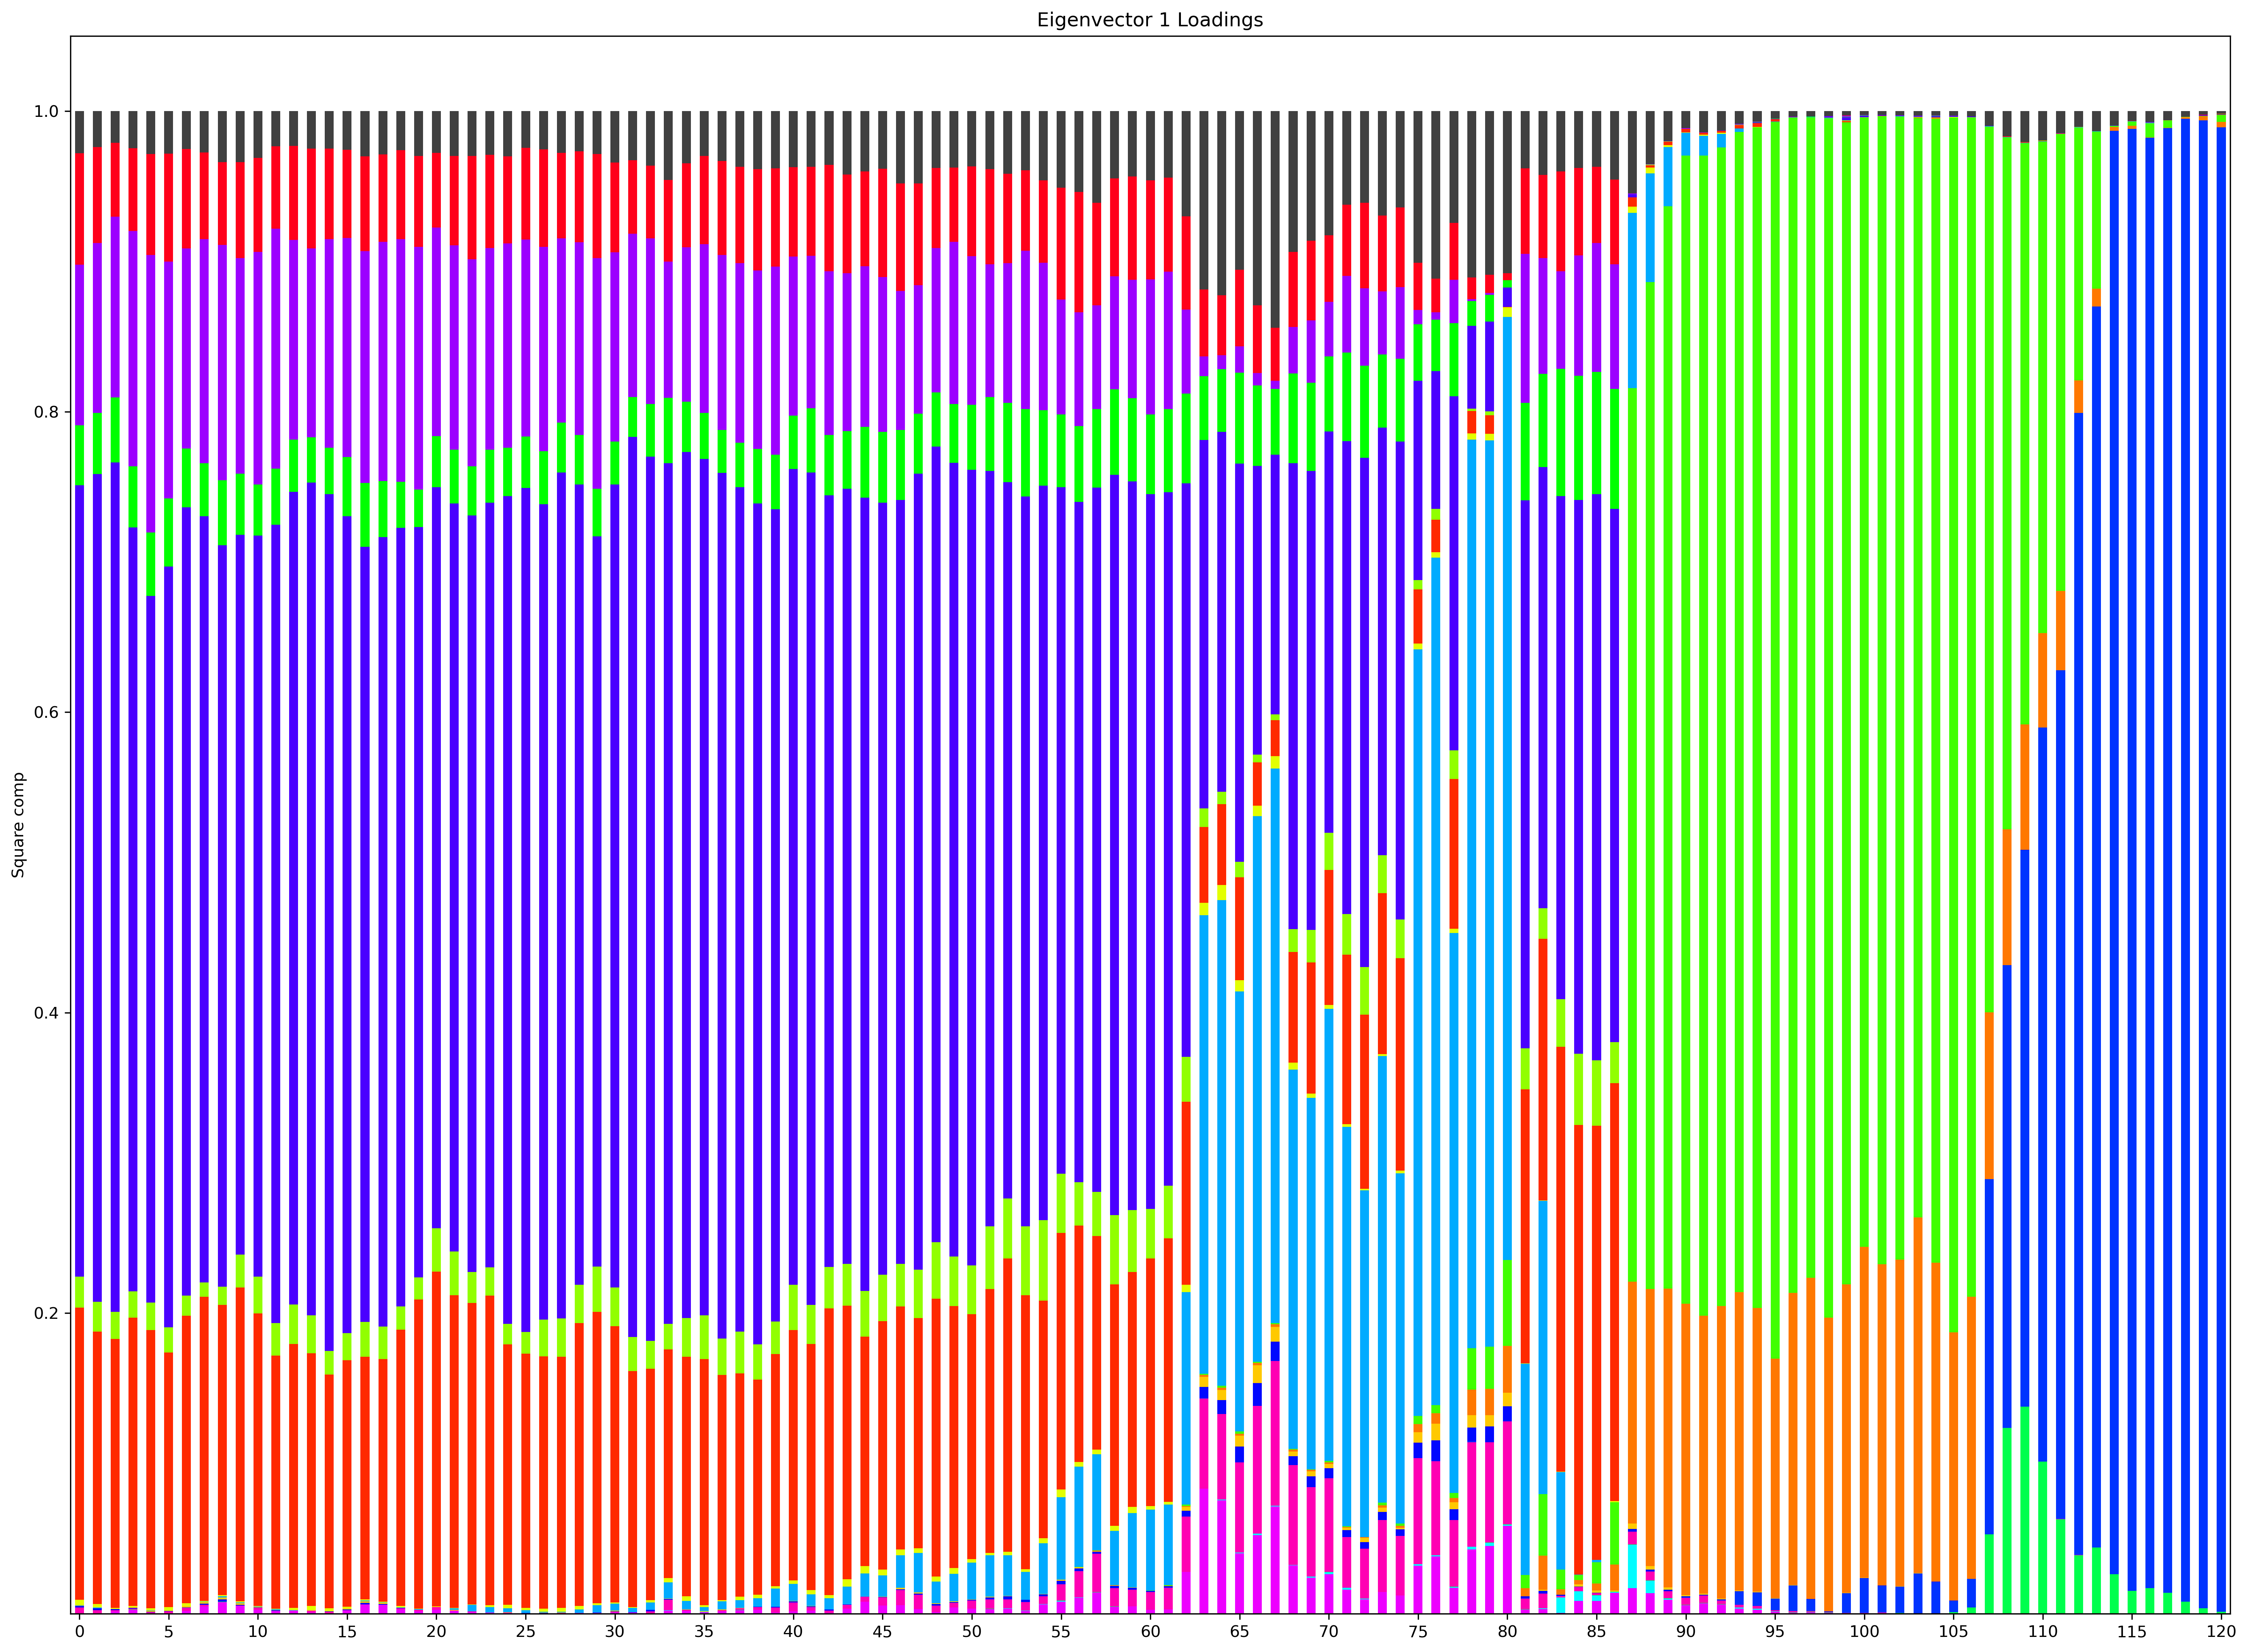

In [57]:
eps = 0.01
idx_subset = list(range(0, 121))
evec_subset = evecs_data[idx_subset, 0, :]
title = "Eigenvector 1 Loadings"
saveas = f"{imgdir}/evec_1_loads_all.png"
data, int_gidxs, int_gnames, cmap = eigenvector_loading_barchart(idx_subset, evec_subset, gnames, eps,
                                        verbose=True, do_table=False, title=title, saveas=saveas, cmap=cmap)

Interesting Genes (29):
['B2m' 'Dlk1' 'Eef1a1' 'Elane' 'Fth1' 'Gapdh' 'Ifitm1' 'Ngp' 'Ptma'
 'Rpl18a' 'Rpl23' 'Rpl27a' 'Rps17' 'Rps23' 'Rps24' 'Rps25' 'S100a8'
 'S100a9' 'Set' 'Srgn' 'Tuba1b' 'Ybx1' 'mt-Atp6' 'mt-Co1' 'mt-Co2'
 'mt-Cytb' 'mt-Nd1' 'mt-Nd2' 'mt-Nd4']


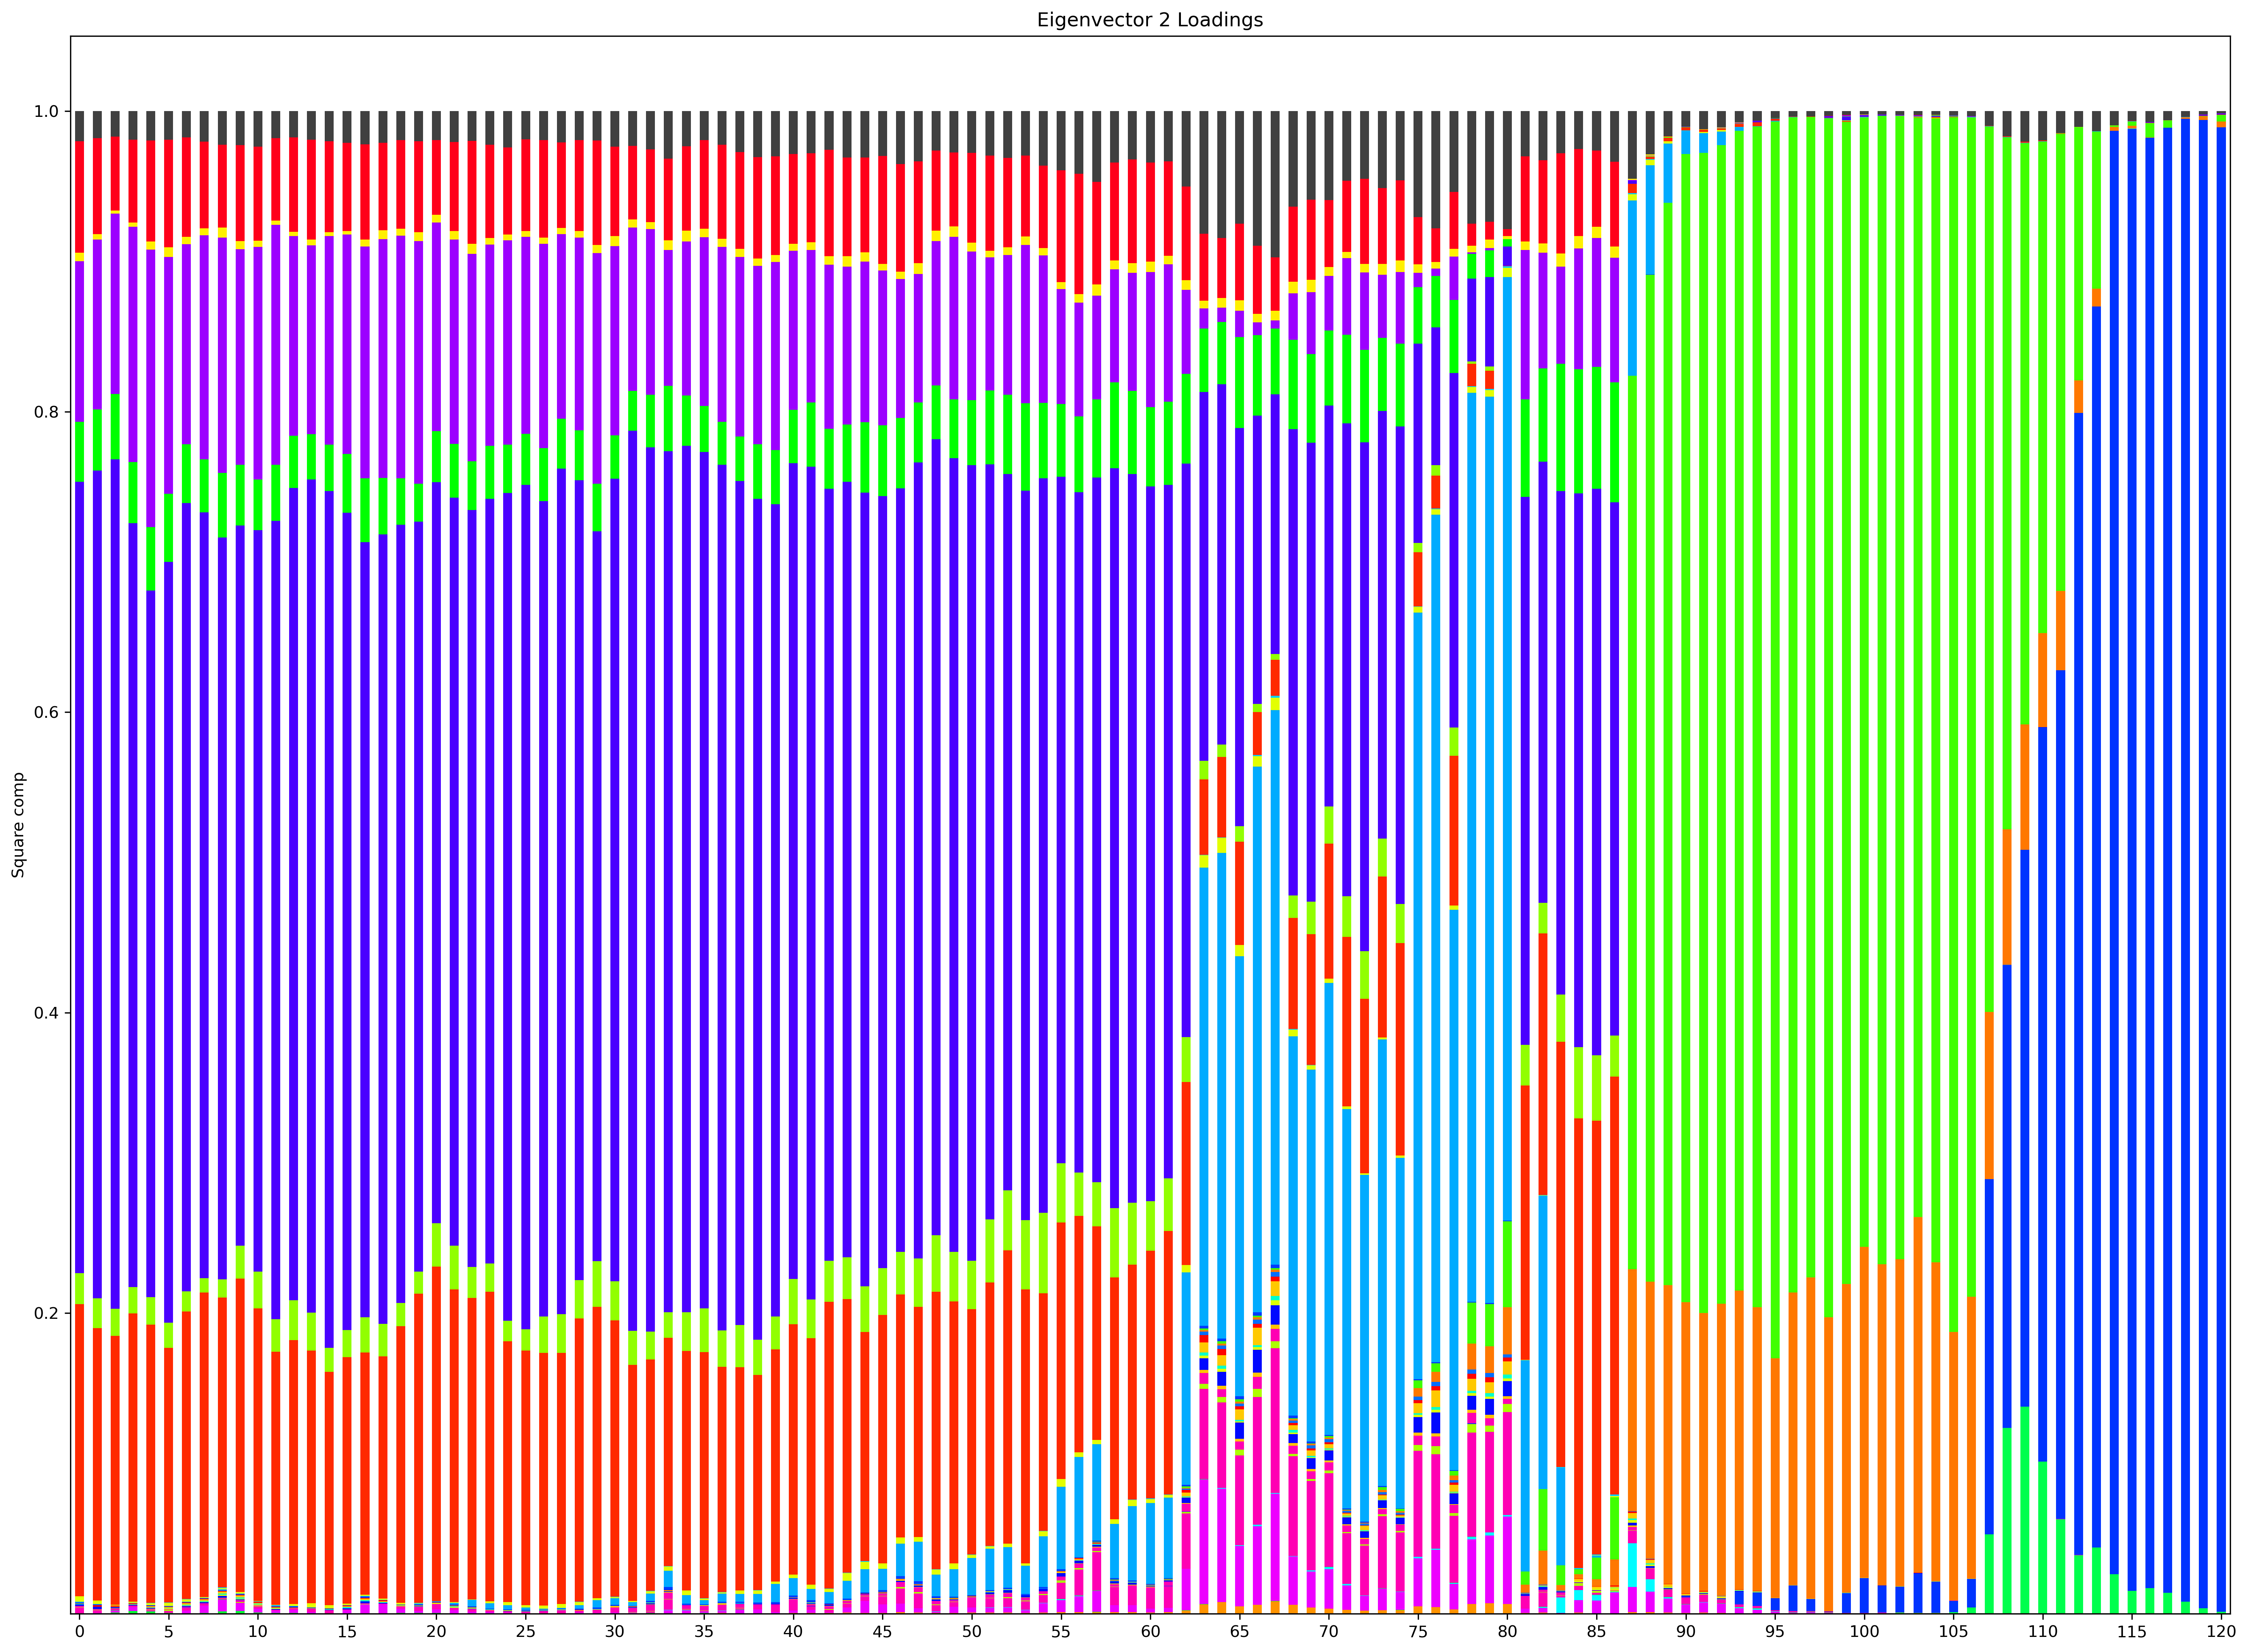

In [58]:
idx_subset = list(range(0, 121))
evec_subset = evecs_data[idx_subset, 1, :]
title = "Eigenvector 2 Loadings"
saveas = f"{imgdir}/evec_2_loads_all.png"
data, int_gidxs, int_gnames, cmap = eigenvector_loading_barchart(idx_subset, evec_subset, gnames, eps,
                                        verbose=True, do_table=False, title=title, saveas=saveas, cmap=cmap)

Interesting Genes (11):
['Eef1a1' 'Gapdh' 'Rpl23' 'Srgn' 'Tuba1b' 'mt-Atp6' 'mt-Co1' 'mt-Co2'
 'mt-Cytb' 'mt-Nd1' 'mt-Nd4']


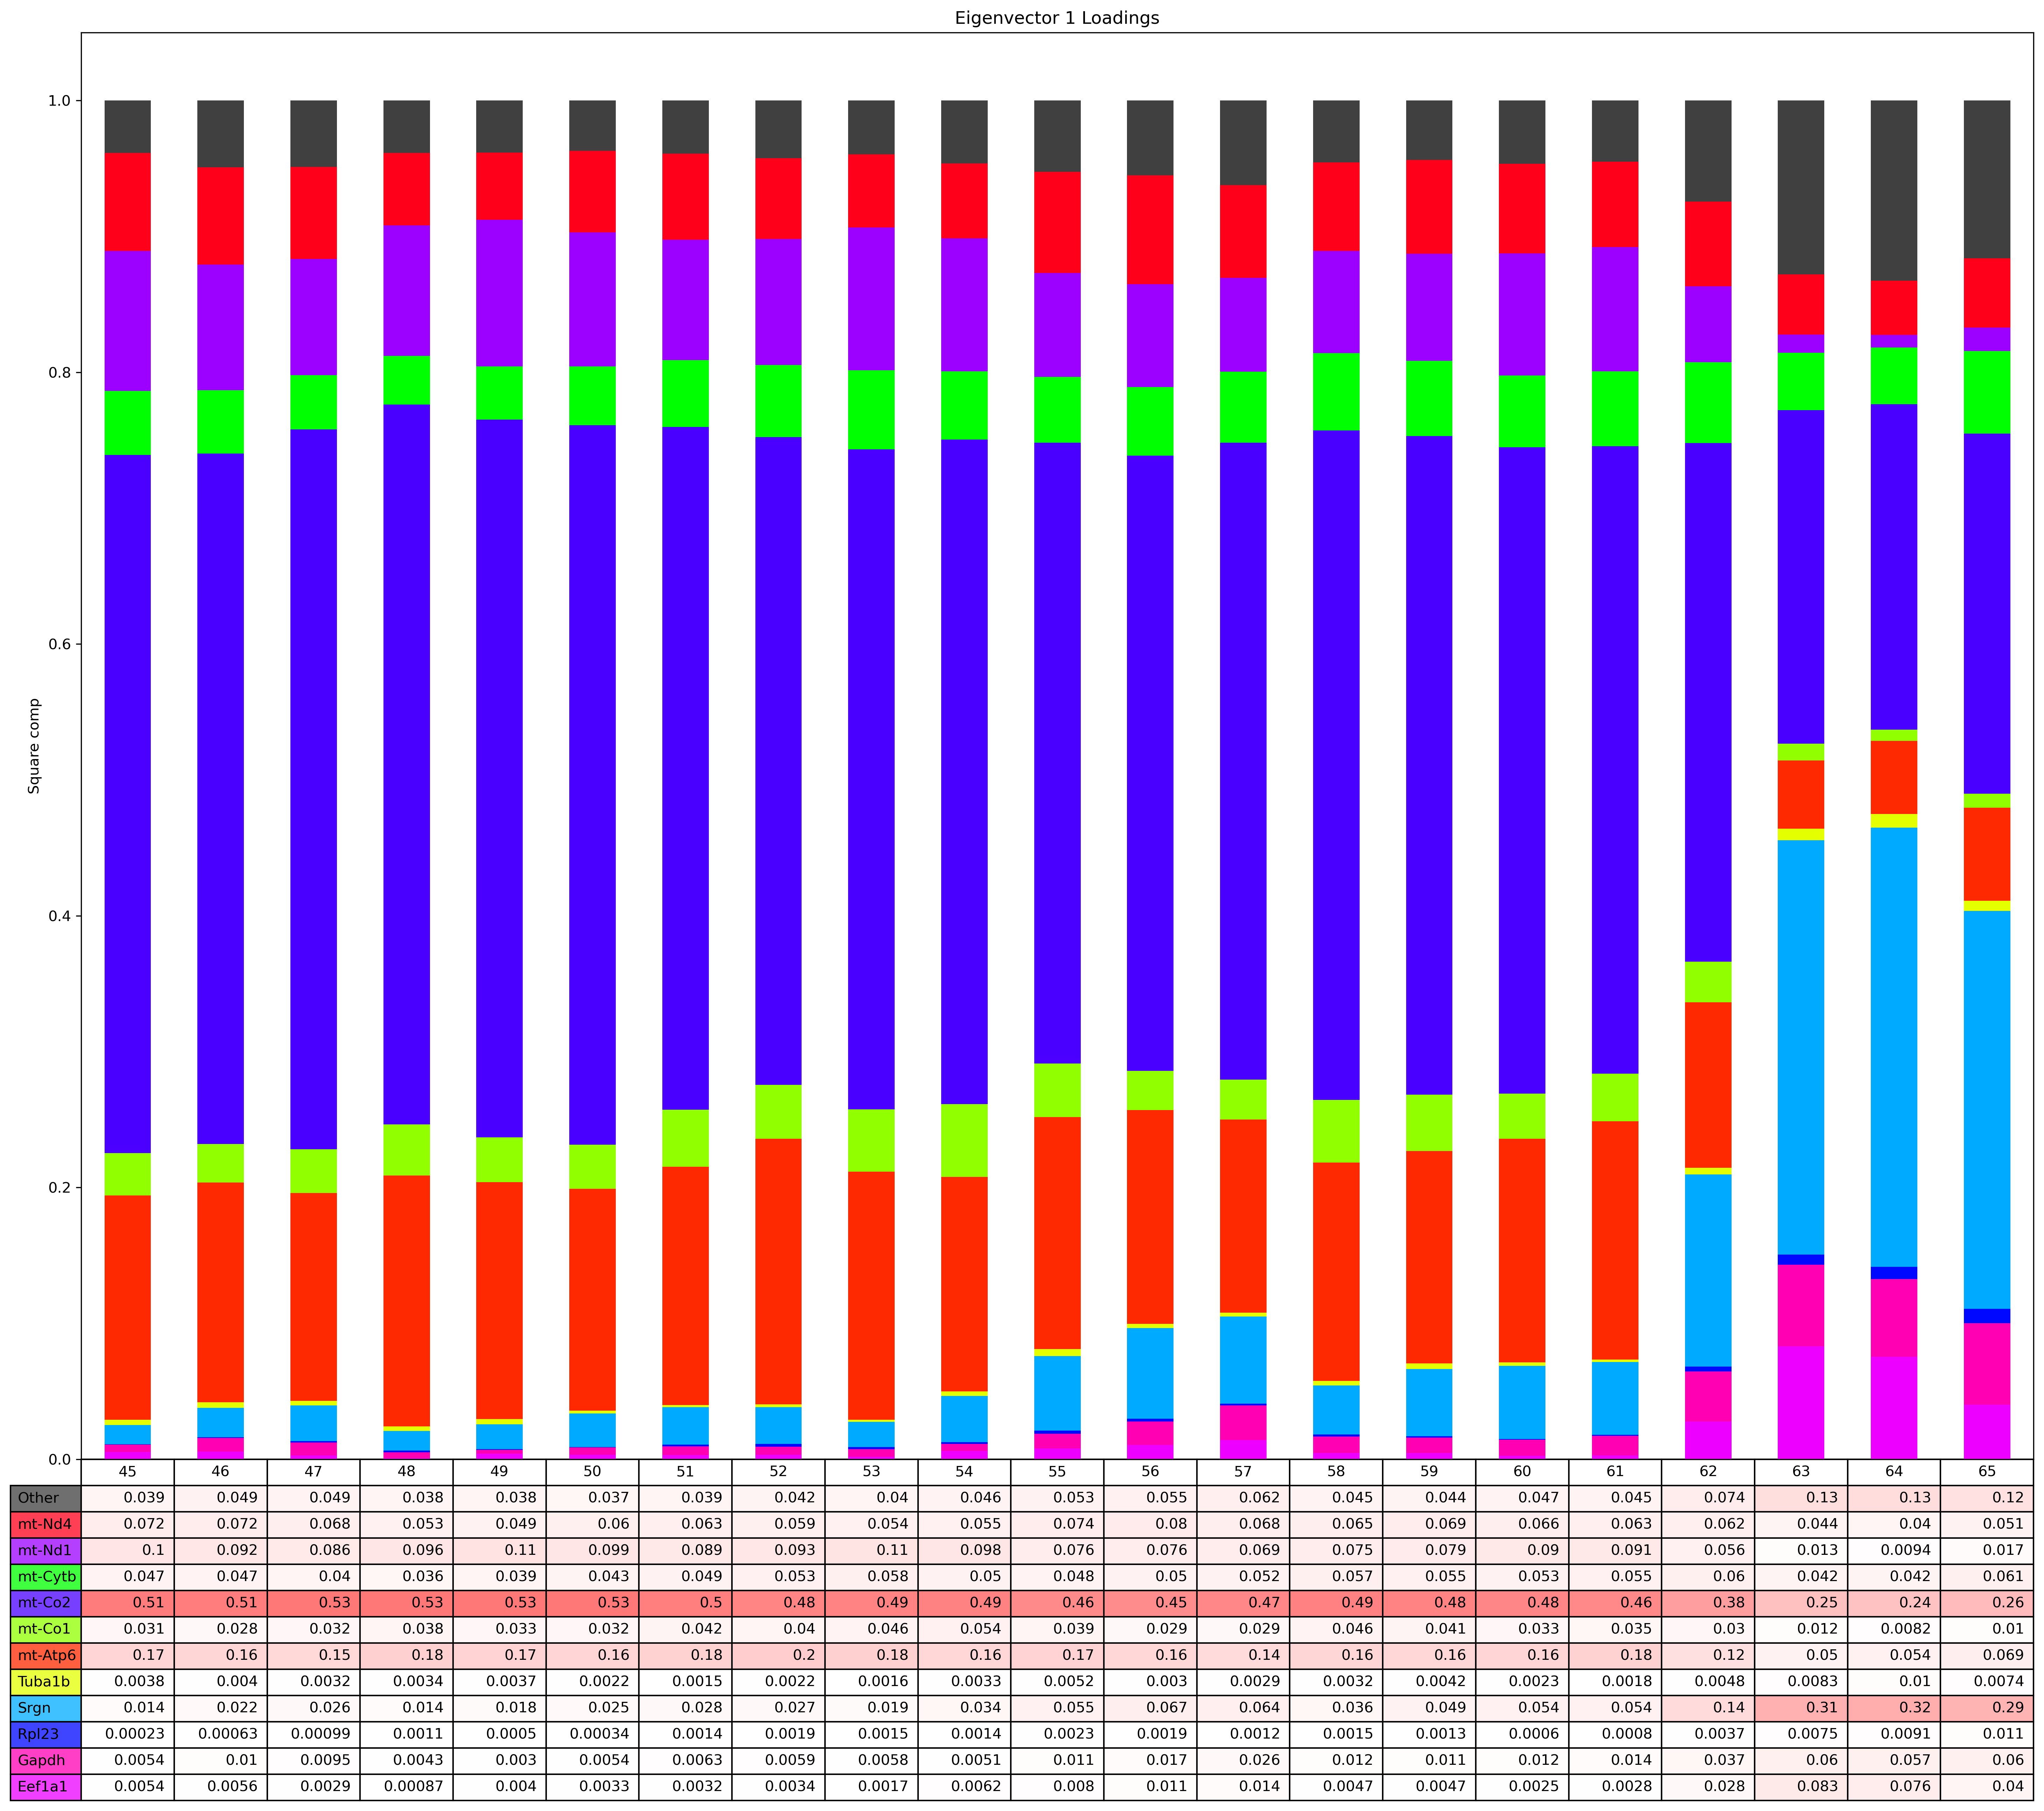

In [59]:
idx_subset = list(range(45, 66))
evec_subset = evecs_data[idx_subset, 0, :]
title = "Eigenvector 1 Loadings"
saveas = f"{imgdir}/evec_1_loads_45_66.png"
data, int_gidxs, int_gnames, cmap = eigenvector_loading_barchart(idx_subset, evec_subset, gnames, eps,
                                        verbose=True, do_table=True, title=title, saveas=saveas, cmap=cmap)

Interesting Genes (14):
['Eef1a1' 'Elane' 'Gapdh' 'Rpl23' 'Rps23' 'S100a8' 'S100a9' 'Srgn'
 'mt-Atp6' 'mt-Co1' 'mt-Co2' 'mt-Cytb' 'mt-Nd1' 'mt-Nd4']


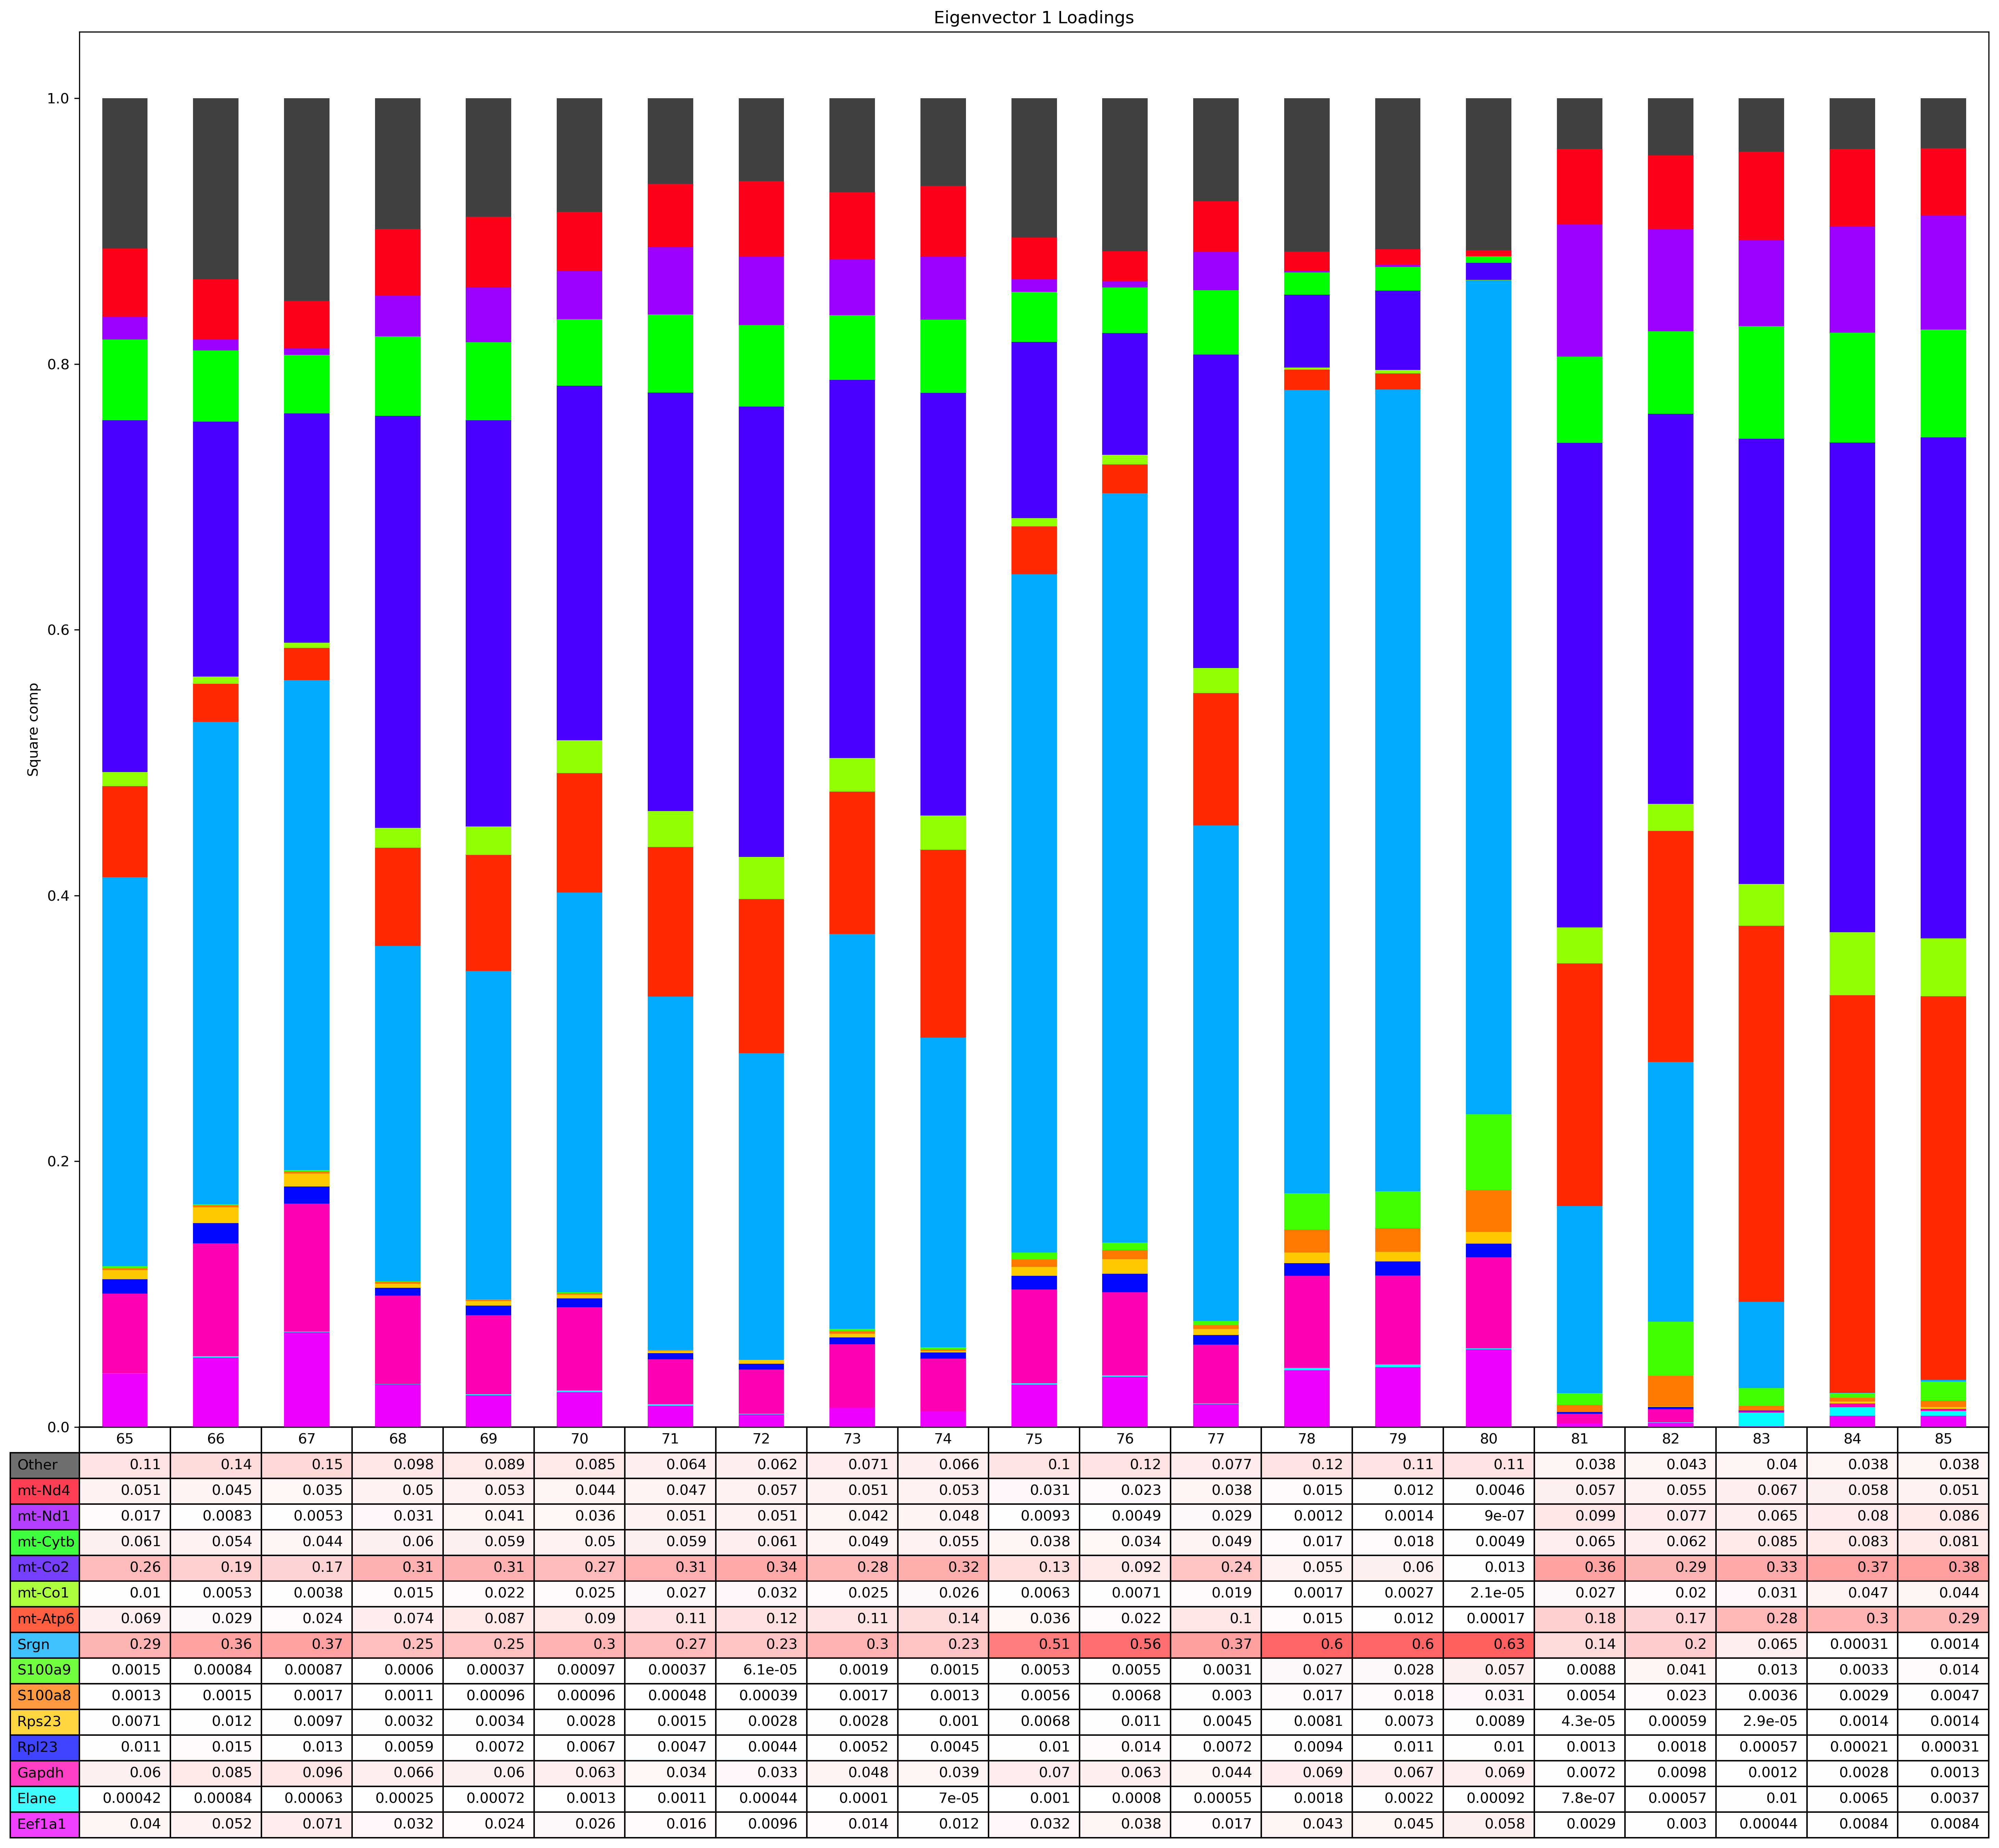

In [60]:
idx_subset = list(range(65, 86))
evec_subset = evecs_data[idx_subset, 0, :]
title = "Eigenvector 1 Loadings"
saveas = f"{imgdir}/evec_1_loads_65_86.png"
data, int_gidxs, int_gnames, cmap = eigenvector_loading_barchart(idx_subset, evec_subset, gnames, eps,
                                        verbose=True, do_table=True, title=title, saveas=saveas, cmap=cmap)

Interesting Genes (15):
['Eef1a1' 'Elane' 'Gapdh' 'Rpl23' 'Rps23' 'S100a8' 'S100a9' 'Srgn'
 'Tuba1b' 'mt-Atp6' 'mt-Co1' 'mt-Co2' 'mt-Cytb' 'mt-Nd1' 'mt-Nd4']


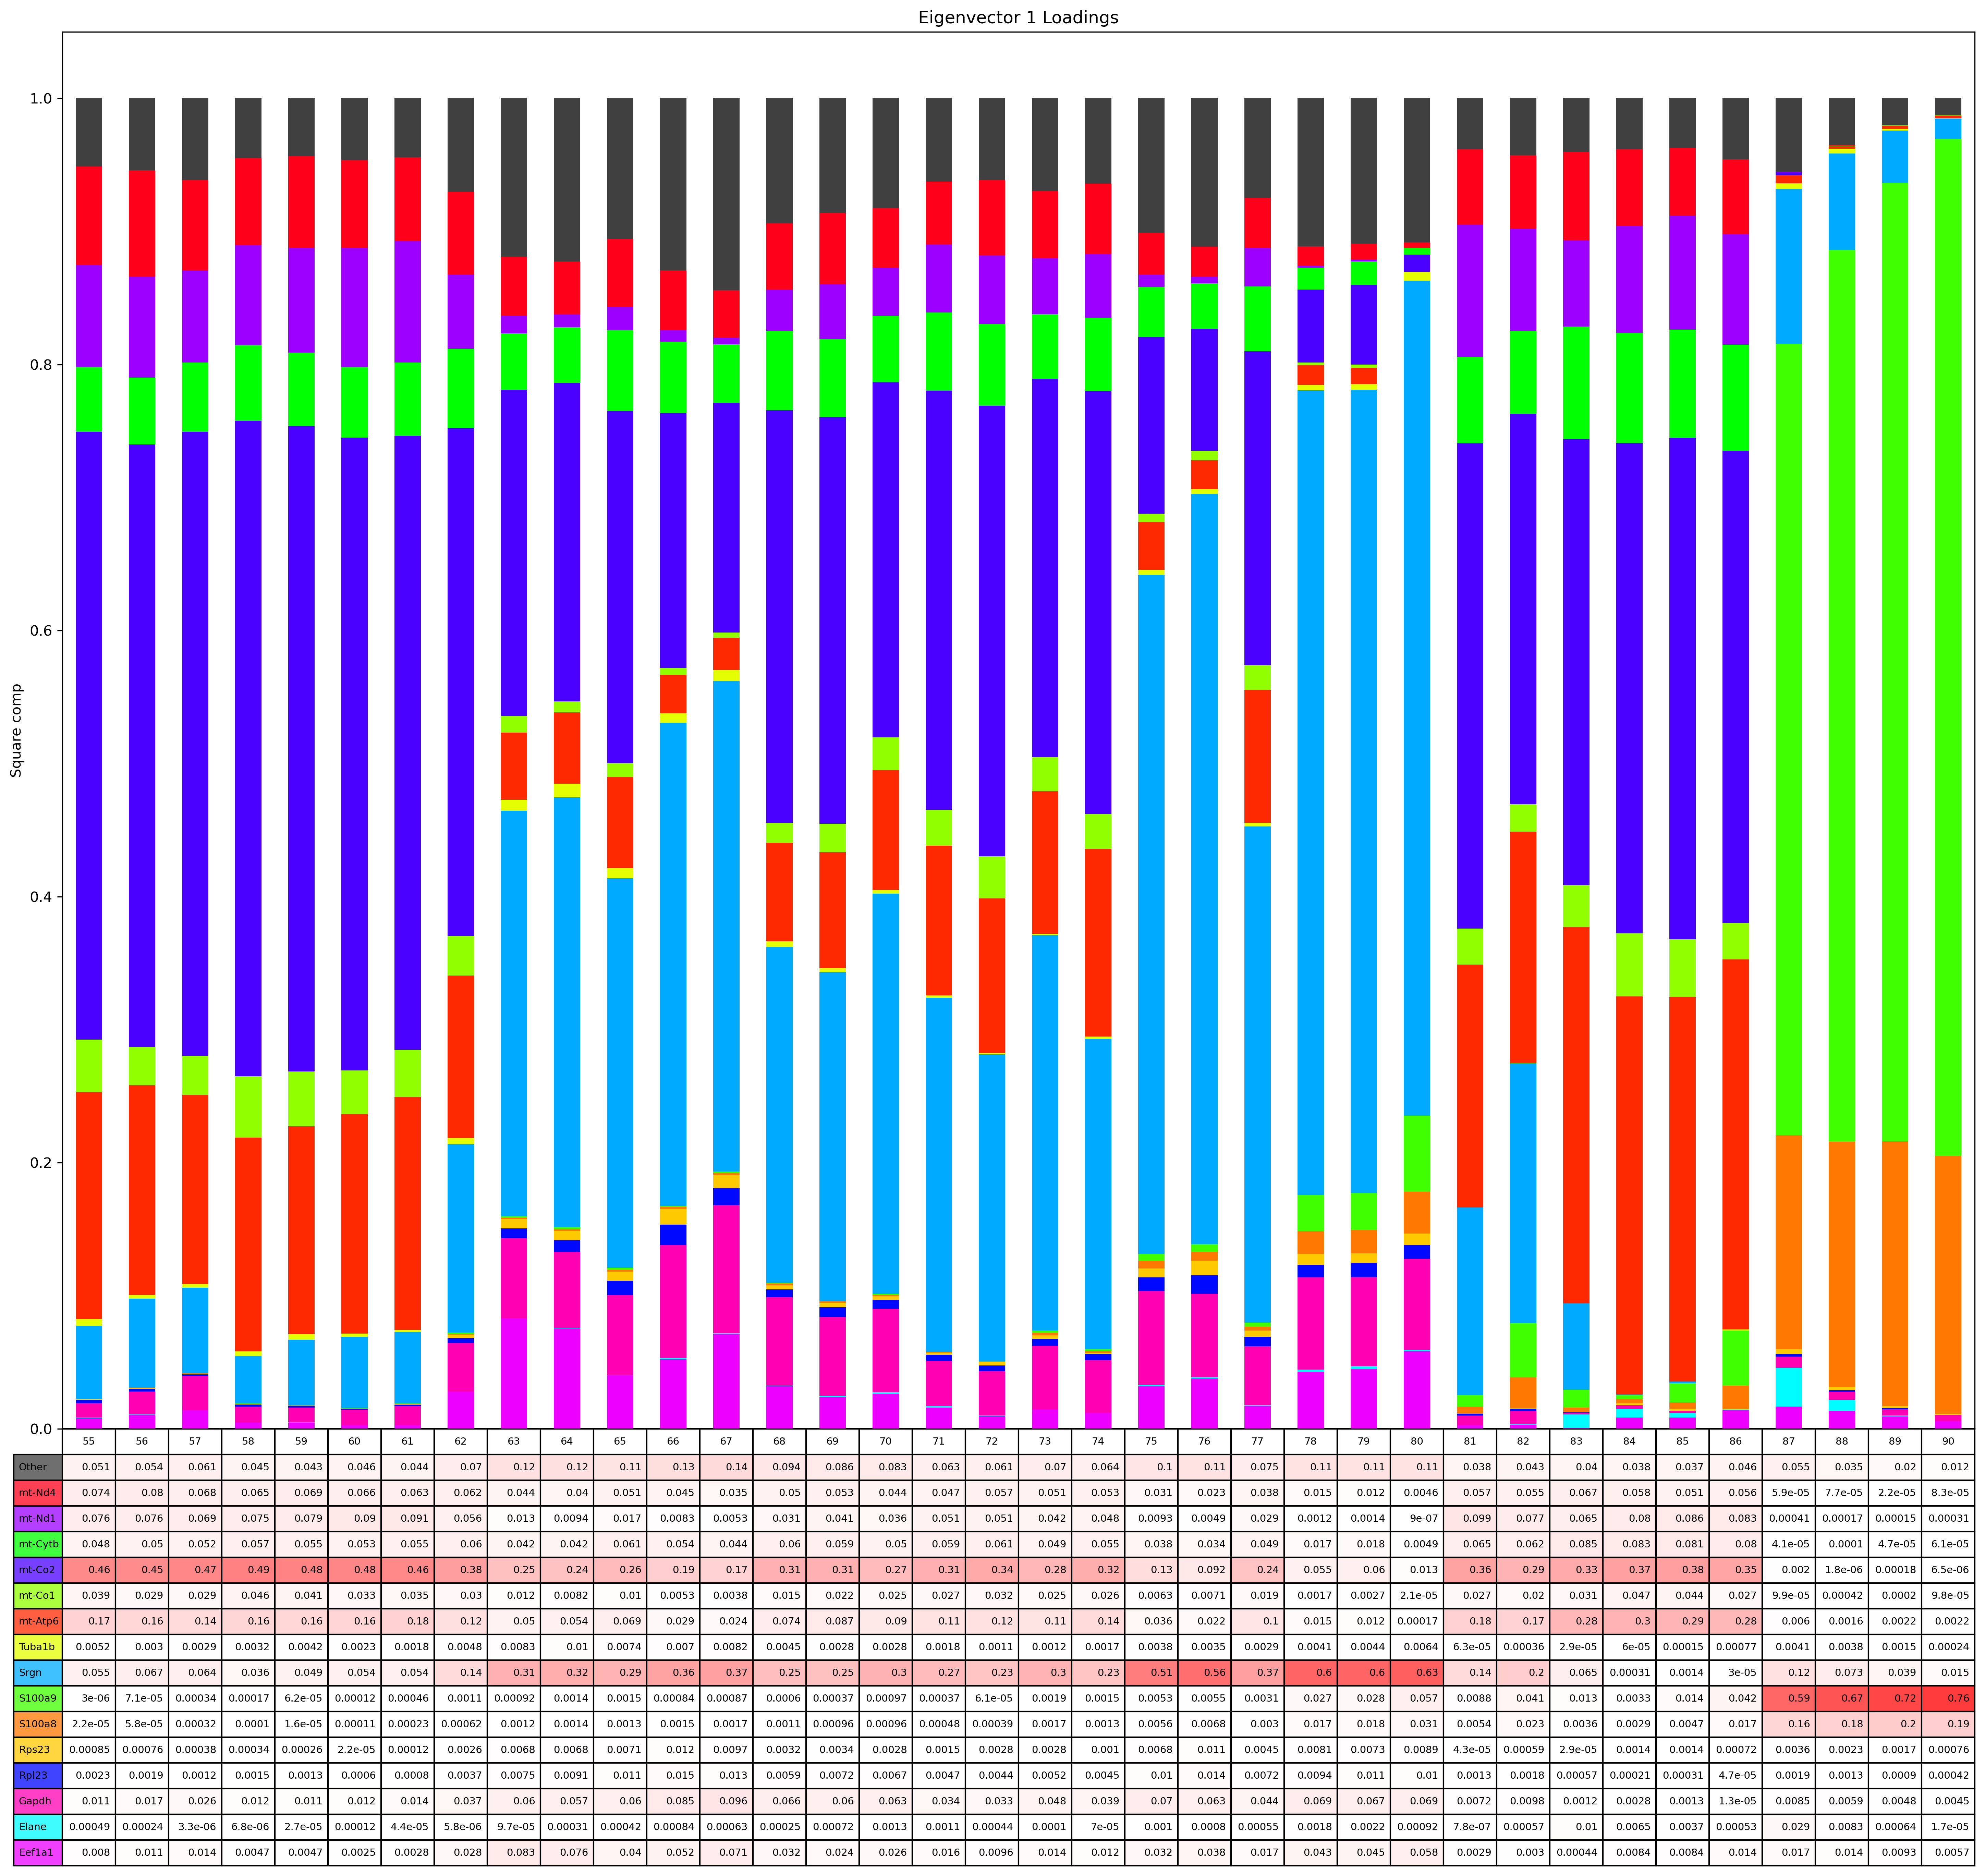

In [61]:
idx_subset = list(range(55, 91))
evec_subset = evecs_data[idx_subset, 0, :]
title = "Eigenvector 1 Loadings"
saveas = f"{imgdir}/evec_1_loads_55_91.png"
data, int_gidxs, int_gnames, cmap = eigenvector_loading_barchart(idx_subset, evec_subset, gnames, eps,
                                        verbose=True, do_table=True, title=title, saveas=saveas, cmap=cmap)

Interesting Genes (4):
['Fth1' 'Ngp' 'S100a8' 'S100a9']


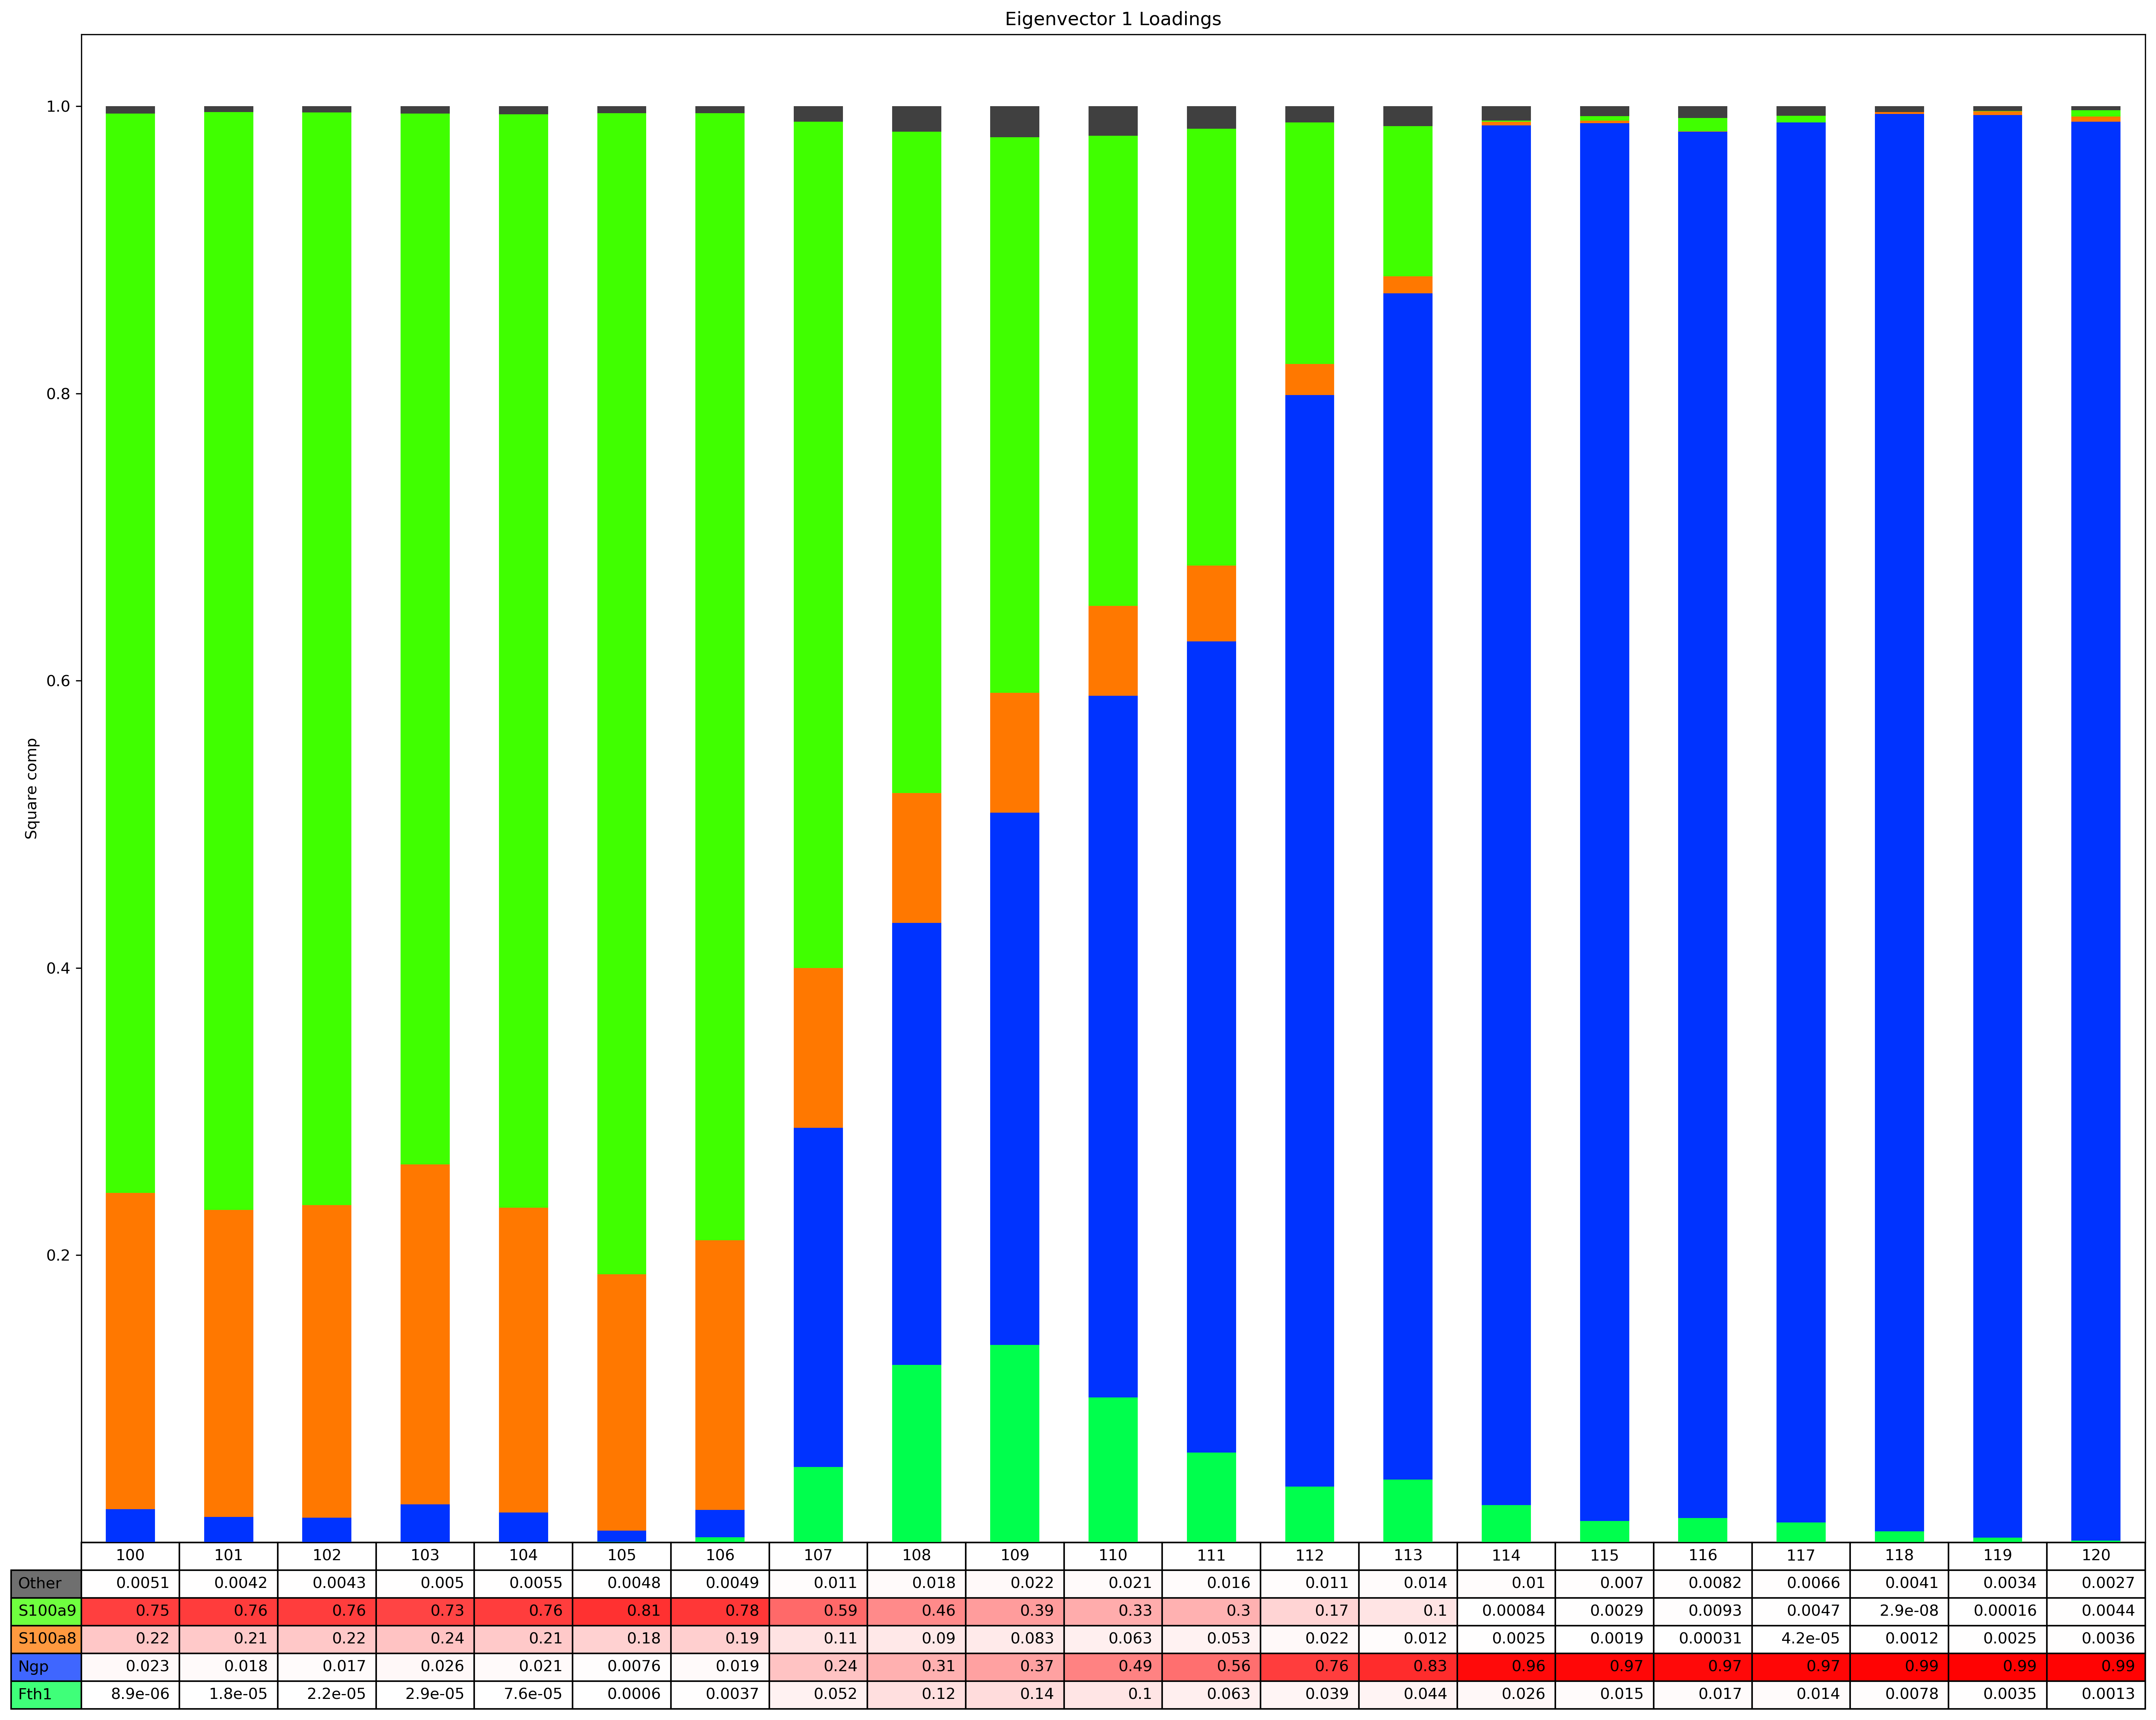

In [62]:
idx_subset = list(range(100, 121))
evec_subset = evecs_data[idx_subset, 0, :]
title = "Eigenvector 1 Loadings"
saveas = f"{imgdir}/evec_1_loads_100_121.png"
data, int_gidxs, int_gnames, cmap = eigenvector_loading_barchart(idx_subset, evec_subset, gnames, eps,
                                        verbose=True, do_table=True, title=title, saveas=saveas, cmap=cmap)